### Imports/Data Loading

In [54]:
import scipy
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nn
scipy.interp = np.interp
from sklearn import metrics as mt

import scikitplot as skplt


import scipy

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

In [2]:
df_raw = pd.read_csv("C:\\Users\\igormagro\\Documents\\PropensaoDeCompra\\data\\train.csv")

# 1.0 Descrição dos Dados


In [3]:
df1 = df_raw.copy()


In [4]:
df1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
df1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.1 Renomeando as colunas

In [6]:
cols_old = df1.columns
snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.3 Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.6. Change Data Types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.7. Descriptive Statistics

In [11]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

In [12]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. PASSO 02 - FEATURE ENGINEERING

In [13]:
df2 = df1.copy()
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [14]:
print(df2['vehicle_age'].unique())

['> 2 Years' '1-2 Year' '< 1 Year']


In [15]:
df2['vehicle_age'] = df2['vehicle_age'].apply(
    lambda x: 'over2years' if x == '> 2 Years'
    else 'between1and2years' if x == '1-2 Year'
    else 'lessthan1year' if x == '< 1 Year'
    else x
)
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)
df2.loc[:,:].groupby('vehicle_damage').size().reset_index(name='counts')

,vehicle_damage,counts
0,0,188696
1,1,192413


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [16]:
df3 = df2.copy()

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [17]:
df4 = df3.copy()

## 4.1. Analise Univariada

<Axes: xlabel='age', ylabel='Count'>

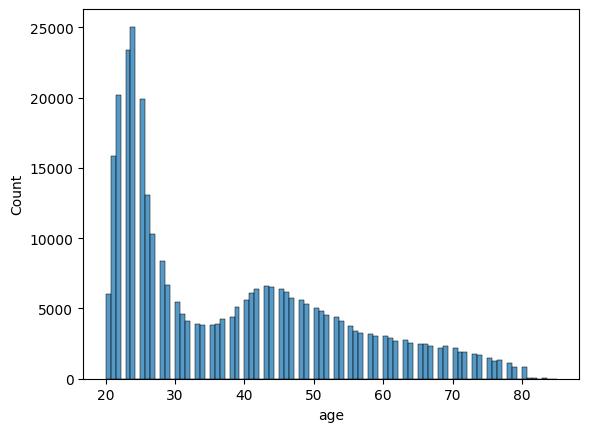

In [18]:
#age
aux = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux)

<Axes: xlabel='age', ylabel='Count'>

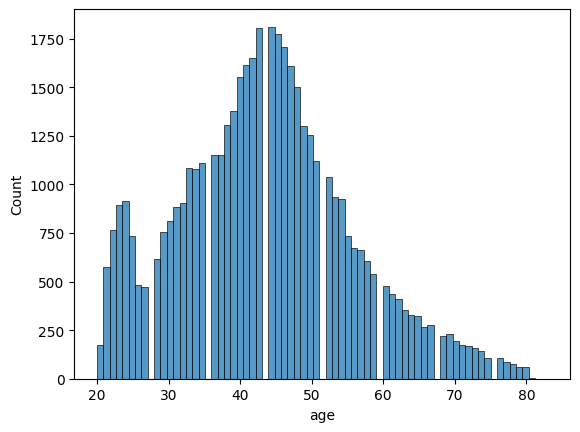

In [19]:
#age
aux = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux)

<Axes: xlabel='annual_premium', ylabel='Count'>

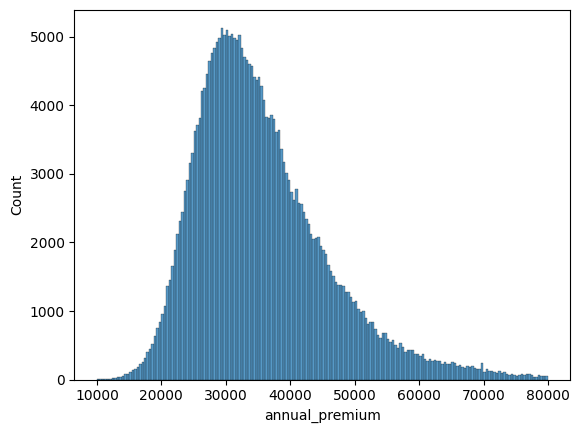

In [20]:
#annual _premium
aux0 = df4[(df4['annual_premium'] < 80000) & (df4['annual_premium'] > 10000)]
aux = aux0.loc[aux0['response'] == 0, 'annual_premium']
sns.histplot(aux)

<Axes: xlabel='annual_premium', ylabel='Count'>

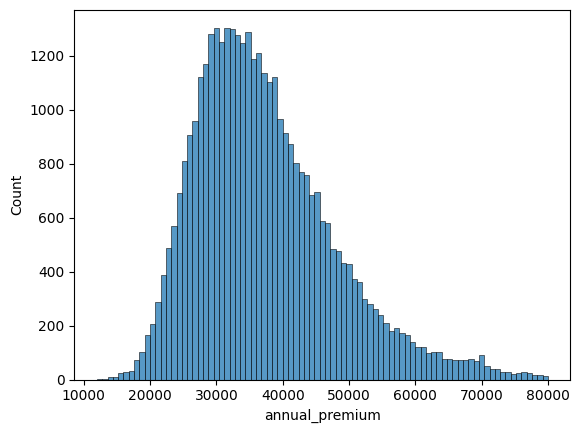

In [21]:
#annual _premium
aux0 = df4[(df4['annual_premium'] < 80000) & (df4['annual_premium'] > 10000)]
aux = aux0.loc[aux0['response'] == 1, 'annual_premium']
sns.histplot(aux)

<Axes: xlabel='response', ylabel='driving_license'>

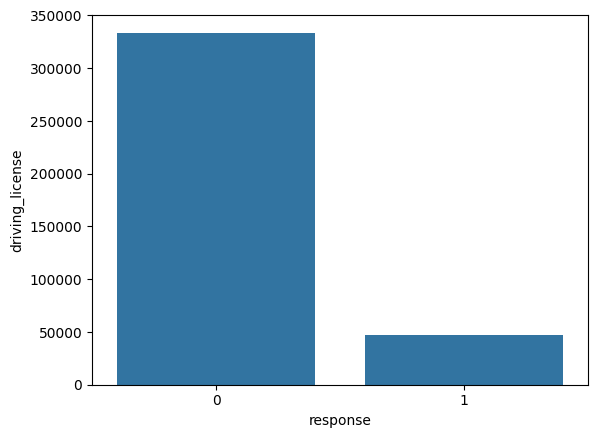

In [22]:
# driving_license
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='driving_license', data=aux)

<Axes: xlabel='region_code', ylabel='id'>

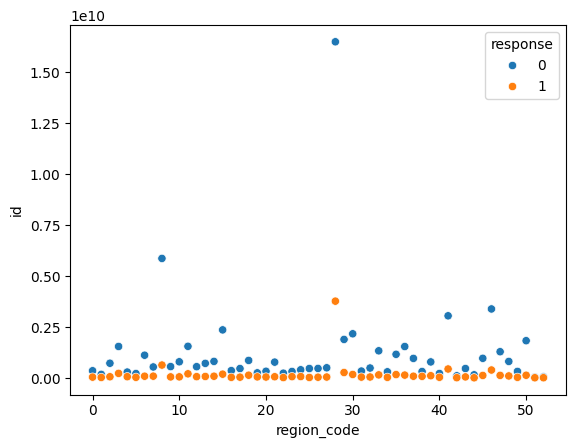

In [23]:
# region_code
aux3 = df4[['id','region_code', 'response']].groupby(['region_code', 'response']).sum().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux3)

In [24]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response'])

response,0,1
previously_insured,,
0,159929,46552
1,174470,158


In [25]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()



,vehicle_age,response,proportion
0,between1and2years,0,0.434285
1,lessthan1year,0,0.413488
2,between1and2years,1,0.091328
3,over2years,0,0.029663
4,lessthan1year,1,0.018897
5,over2years,1,0.012338


In [26]:
#vehicle_damage
pd.crosstab(df4['vehicle_damage'], df4['response'])

response,0,1
vehicle_damage,,
0,187714,982
1,146685,45728


<Axes: xlabel='response', ylabel='policy_sales_channel'>

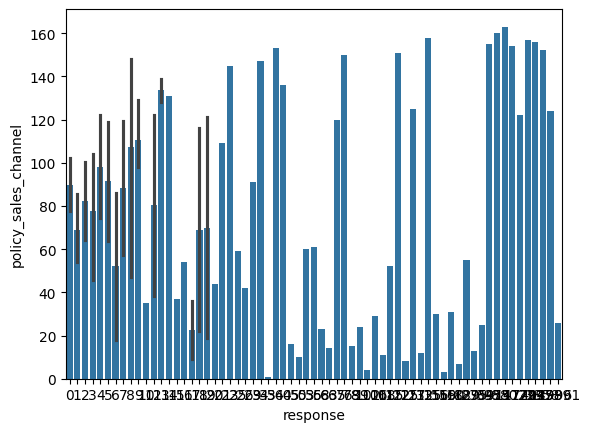

In [27]:
#policy_sales_channel
aux = df3[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data = aux)

## 4.2. Analise Bivariada

## 4.3. Analise Multivariada

# 5.0. PASSO 05 - DATA PREPARATION

In [28]:
df5 = df4.copy()
df5.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 5.1. Normalizacao


In [29]:
ss = pp.StandardScaler()
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)


## 5.2. Rescaling


In [30]:
# age 
rs = RobustScaler()
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()
df5['age'] = mms_age.fit_transform(df5[['age']].values)
# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)


## 5.3. Transformacao





### 5.3.1. Encoding

In [31]:
# Target Encoding for gender
target_encoding_gender = df5[['gender', 'response']].groupby('gender').mean()['response']
df5['gender'] = df5['gender'].map(target_encoding_gender)

# Target Encoding for region_code
target_encoding_region_code = df5[['region_code', 'response']].groupby('region_code').mean()['response']
df5['region_code'] = df5['region_code'].map(target_encoding_region_code)

df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])
# Frequency Encoding for policy_sales_channel
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)


# 6.0. Data Prepraration


## 6.1. Data Split and Validation Preparation

In [32]:
X = df5.drop('response', axis=1)
Y = df5['response']






X_train, X_val, Y_train, Y_val = ms.train_test_split(X, Y, test_size=0.2)
df6 = pd.concat([X_train, Y_train], axis=1)



# 7.0. Feature Selection

In [33]:
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)
X_train_n = df6.drop(['id', 'response'], axis=1)
Y_train_n = Y_train.values
X_train_n = df6.drop(['id','response'], axis=1)
Y_train_n = df6.loc[X_train_n.index, 'response'].values

forest.fit(X_train_n, Y_train_n)       

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
1. feature 8 (0.271870)
2. feature 6 (0.243681)
3. feature 1 (0.166976)
4. feature 3 (0.105649)
5. feature 5 (0.070594)
6. feature 7 (0.059949)
7. feature 4 (0.053866)
8. feature 10 (0.013780)
9. feature 9 (0.006364)
10. feature 0 (0.004564)
11. feature 11 (0.002208)
12. feature 2 (0.000499)


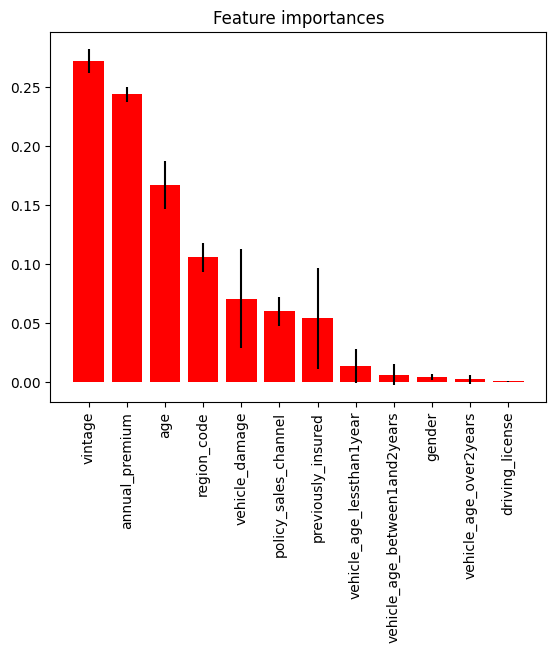

In [34]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X_train_n.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_n.shape[1]), X_train_n.columns[indices], rotation=90)
plt.xlim([-1, X_train_n.shape[1]])
plt.show()

# 8.0. Machine Learning

In [35]:
cols_selected = ['annual_premium', 'age', 'vintage', 'region_code', 'policy_sales_channel', 'previously_insured', 'vehicle_damage']   
X_train = df6[cols_selected]
X_val = X_val[cols_selected]
Y_train = df6.loc[X_train.index, 'response'].values


## 8.1. KNN

In [36]:
#model
knn = nn.KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, Y_train)
# prediction
Y_pred_knn = knn.predict_proba(X_val)

<Axes: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

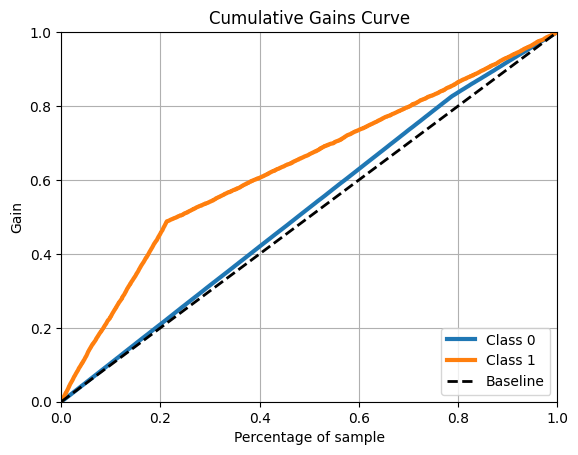

In [38]:
skplt.metrics.plot_cumulative_gain(Y_val, Y_pred_knn)

In [39]:
#model accuracy
print("Accuracy: {:.2f}%".format(knn.score(X_val, Y_val) * 100))

Accuracy: 86.28%


## 8.2. Random Forest Classifier

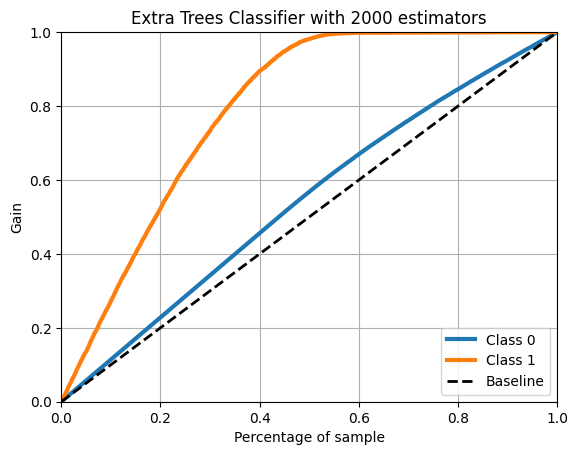

Accuracy with 2000 estimators: 86.28%
Recall with 2000 estimators: 11.71%
Precision with 2000 estimators: 34.21%


In [55]:



forest = en.RandomForestClassifier(n_estimators=2000, random_state=0, n_jobs=-1)
forest.fit(X_train, Y_train)
Y_pred_rf = forest.predict_proba(X_val)
skplt.metrics.plot_cumulative_gain(Y_val, Y_pred_rf)
plt.title(f'Extra Trees Classifier with 2000 estimators')
plt.show()
#ACC    
print("Accuracy with {} estimators: {:.2f}%".format(2000, forest.score(X_val, Y_val) * 100))
#Recall
print("Recall with {} estimators: {:.2f}%".format(2000, mt.recall_score(Y_val, forest.predict(X_val)) * 100))
#Precision
print("Precision with {} estimators: {:.2f}%".format(2000, mt.precision_score(Y_val, forest.predict(X_val)) * 100))



# 9.0. Model Statistics

In [42]:
def recall_at_k(data, k):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    return data.loc[k, 'recall_at_k']

In [40]:
def precision_at_k(data, k):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['precision_at_k'] = (data['response'].cumsum() / (data['ranking']))
    return data.loc[k, 'precision_at_k']

In [ ]:
df7 = X_val.copy()
df7['response'] = Y_val.copy()

df7['score'] = Y_pred_knn[:, 1].tolist()

df7 = df7.sort_values(by='score', ascending=False)
#precision at k
prec_at_50 = precision_at_k(df7, 50)
print(prec_at_50)
#recall at k
rec_at_50 = recall_at_k(df7, 50)
print(rec_at_50)

df7_rf = X_val.copy()
df7_rf['response'] = Y_val.copy()
df7_rf['score'] = Y_pred_rf[:, 1].tolist()
df7_rf = df7_rf.sort_values(by='score', ascending=False)
#precision at k_rf
prec_at_50_rf = precision_at_k(df7_rf, 50)
print(prec_at_50_rf)
#recall at k_rf
rec_at_50_rf = recall_at_k(df7_rf, 50)
print(rec_at_50_rf)
#

0.1568627450980392
0.000847457627118644
0.3137254901960784
0.001694915254237288
